# Import libraries & settings

In [1]:
import os

import pandas as pd

from bs4 import BeautifulSoup

import shutil

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 200)

In [3]:
# Path to root folder
dir_path = 'C:/Users/Adam/Documents/Out of the Park Developments/OOTP Baseball 24/saved_games/'

# Destination folder for processed game logs
destination_folder_pitchers = 'C:/Users/Adam/Desktop/OOTP/Pitchers_historical_logs'
destination_folder_batters = 'C:/Users/Adam/Desktop/OOTP/Batters_historical_logs'

# Destination folder for final data sets
destination_folder = 'C:/Users/Adam/Desktop/OOTP'

# Import and process logs

In [4]:
# Import HTML files
html_files = []

for root, dirs, files in os.walk(dir_path):
    if 'html' in dirs:
        temp_dir = os.path.join(root, 'html')
        if 'temp' in os.listdir(temp_dir):
            html_dir = os.path.join(temp_dir, 'temp')
            for file in os.listdir(html_dir):
                if file.endswith('.html'):
                    html_files.append(os.path.join(html_dir, file))


In [5]:
# Load the parquet "DBs" into a Pandas DataFrame
# https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d
# feather was impossible to set up
df_pitchers = pd.read_parquet(r'C:\Users\Adam\Desktop\OOTP\pitchers_db.parquet')
df_batters = pd.read_parquet(r'C:\Users\Adam\Desktop\OOTP\batters_db.parquet')

In [6]:
# ETL for new logs

for file in tqdm(html_files):
    # Reading the HTML file into a pandas DataFrame
    df = pd.read_html(file, flavor = 'bs4', skiprows=[0])[0]
    
    # delete the first row
    df = df.drop(0)
    # set the header and drop the row
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    
    # Check for duplicate column names
    duplicate_cols = df.columns[df.columns.duplicated()]
    # print(duplicate_cols) 

    # Get a boolean mask indicating which column names are duplicates
    dupe_mask = df.columns.duplicated()

    # Add a suffix to duplicate column names
    df.columns = df.columns.where(~dupe_mask, df.columns + '_other')
    
    # Concatenate the DataFrames for pitchers and batters independently
    if df.columns[6] == "STU":
        df_pitchers = pd.concat([df_pitchers, df])
        # Move
        shutil.move(file, destination_folder_pitchers)
    else:
        # Drop first column for batters
        df = df.drop(df.columns[0], axis=1)
        # Concat
        df_batters = pd.concat([df_batters, df])
        # Move
        shutil.move(file, destination_folder_batters)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [06:55<00:00, 34.65s/it]


In [7]:
# Store unaggregated data between sessions in parquet file
df_pitchers.to_parquet(r'C:\Users\Adam\Desktop\OOTP\pitchers_db.parquet')
df_batters.to_parquet(r'C:\Users\Adam\Desktop\OOTP\batters_db.parquet')

# Prepare Dataframes

## Data Types

### Pitchers

In [8]:
pitchers_data_types = {
                "POS": str, "Name": str, "ORG": str, "B": str, "T": str, "OVR": int, "STU": int,
                "MOV": int, "CON": int, "PBABIP": int, "HRR": int, "STU vL": int, "MOV vL": int,
                "CON vL": int, "PBABIP vL": int, "HRR vL": int, "STU vR": int, "MOV vR": int,
                "CON vR": int, "PBABIP vR": int, "HRR vR": int, "FB": int, "CH": int, "CB": int,
                "SL": int, "SI": int, "SP": int, "CT": int, "FO": int, "CC": int, "SC": int,
                "KC": int, "KN": int, "PIT": int, "G/F": str, "VELO": str, "Slot": str, "PT": str,
                "STM": int, "HLD": int, "IF RNG": int, "IF ERR": int, "IF ARM": int, "P": int,
                "G": int, "GS": int, "W": int, "L": int, "WIN%": float, "SVO": int, "SV": int,
                "SV%": float, "BS": int, "BS%": float, "HLD_other": int, "SD": int, "MD": int,
                "IP": float, "BF": int, "AB": int, "HA": int, "1B": int, "2B": int, "3B": int,
                "HR": int, "TB": int, "R": int, "ER": int, "BB": int, "IBB": int, "K": int,
                "HP": int, "ERA": float, "AVG": float, "OBP": float, "SLG": float, "OPS": float,
                "BABIP": float, "WHIP": float, "RA/9": float, "HR/9": float, "H/9": float,
                "BB/9": float, "K/9": float, "K/BB": float, "K%": float, "BB%": float,
                "K%-BB%": float, "SH": int, "SF": int, "WP": int, "BK": int, "CI": int, "DP": int,
                "RA": int, "GF": int, "IR": int, "IRS": int, "IRS%": float, "LOB%": float,
                "pLi": float, "GF%": float, "QS": int, "QS%": float, "CG": int, "CG%": float,
                "SHO": int, "PPG": int, "RS": int, "RSG": float, "PI": int, "GB": int,
                "FB_other": int, "GO%": float, "SB": int, "CS": int, "ERA+": int, "FIP": float,
                "FIP-": float, "WPA": float, "WAR": float, "rWAR": float, "SIERA": float,
                "TC": int, "A": int, "PO": int, "E": int, "DP_other": int, "TP": int, "PCT": float,
                "RNG": float, "ZR": float, "EFF": float}

In [9]:
for col, dtype in pitchers_data_types.items():
    if df_pitchers[col].dtype != dtype and dtype != 'str':
        df_pitchers[col] = df_pitchers[col].replace('-', 0)
        #df_pitchers[col] = pd.to_numeric(df_pitchers[col], errors='coerce').astype(dtype)
        df_pitchers[col] = df_pitchers[col].astype(dtype, errors = 'ignore')
        

In [10]:
df_pitchers = df_pitchers.convert_dtypes().reset_index(drop=True)
df_pitchers['VELO'] = df_pitchers['VELO'].str.split('-').str[0]

In [11]:
# decimal format of innings pitched 
df_pitchers['IP'] = df_pitchers['IP'].apply(lambda x: int(x) + (x % 1 * 10) / 3)

### Batters

In [12]:
batters_data_types = {'POS': str, 'Name': str, 'ORG': str, 'Lev': str, 'HT': str, 'B': str, 'T': str, 'OVR': int, 
                'BABIP': int, 'CON': int, 'GAP': int, 'POW': int, 'EYE': int, 'K\'s': int, 'BABIP vL': int, 
                'CON vL': int, 'GAP vL': int, 'POW vL': int, 'EYE vL': int, 'K vL': int, 'BABIP vR': int, 
                'CON vR': int, 'GAP vR': int, 'POW vR': int, 'EYE vR': int, 'K vR': int, 'BUN': int, 'BFH': int, 
                'BBT': str, 'GBT': str, 'FBT': str, 'C ABI': int, 'C ARM': int, 'IF RNG': int, 'IF ERR': int, 
                'IF ARM': int, 'TDP': int, 'OF RNG': int, 'OF ERR': int, 'OF ARM': int, 'DEF': int, 'P': int, 
                'C': int, '1B': int, '2B': int, '3B': int, 'SS': int, 'LF': int, 'CF': int, 'RF': int, 'SPE': int, 
                'STE': int, 'RUN': int, 'G': int, 'GS': int, 'PA': int, 'AB': int, 'H': int, '1B_other': int, 
                '2B_other': int, '3B_other': int, 'HR': int, 'RBI': int, 'R': int, 'BB': int, 'BB%': float, 'IBB': int, 
                'HP': int, 'SH': int, 'SF': int, 'CI': int, 'SO': int, 'SO%': float, 'GIDP': int, 'EBH': int, 'TB': int, 
                'AVG': float, 'OBP': float, 'SLG': float, 'RC': float, 'RC/27': float, 'ISO': float, 'wOBA': float, 'OPS': float,  
                'OPS+': int, 'BABIP_other': float, 'WPA': float, 'wRC': int, 'wRC+': int, 'wRAA': float, 'WAR': float, 
                'PI/PA': float, 'SB': int, 'CS': int, 'SB%': float, 'BatR': float, 'wSB': float, 'UBR': float, 'BsR': float, 
                'G_other': int, 'GS_other': int, 'TC': int, 'A': int, 'PO': int, 'E': int, 'DP': int, 'TP': int, 
                'PCT': float, 'RNG': float, 'ZR': float, 'EFF': float, 'SBA': int, 'RTO': int, 'RTO%': float, 'IP': float, 
                'PB': int, 'CER': int, 'CERA': float, 'BIZ-R%': float, 'BIZ-R': int, 'BIZ-Rm': int, 'BIZ-L%': float, 
                'BIZ-L': int, 'BIZ-Lm': int, 'BIZ-E%': float, 'BIZ-E': int, 'BIZ-Em': int, 'BIZ-U%': float, 
                'BIZ-U': int, 'BIZ-Um': int, 'BIZ-Z%': float, 'BIZ-Z': int, 'BIZ-Zm': int, 'BIZ-I': int, 'FRM': float, 
                'ARM': float, 'BF%': float}


In [13]:
df_batters['GS'].fillna('0', inplace=True)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [14]:
for col, dtype in batters_data_types.items():
    if df_batters[col].dtype != dtype and dtype != 'str':
        df_batters[col] = df_batters[col].replace('-', 0)
        #df_batters[col] = pd.to_numeric(df_batters[col], errors='coerce').astype(dtype)
        if col in ['BIZ-R%', 'BIZ-L%', 'BIZ-E%', 'BIZ-U%', 'BIZ-Z%', 'BF%']:
            df_batters[col] = df_batters[col].str.replace('%', '')
        df_batters[col] = df_batters[col].astype(dtype, errors = 'ignore')

In [15]:
df_batters = df_batters.convert_dtypes().reset_index(drop=True)

## Aggregations

### Pitcher aggregations

In [16]:
# # too slow
# wm = lambda x: np.average(x, weights=df_pitchers.loc[x.index, 'IP']) if df_pitchers.loc[x.index, 'IP'].sum() > 0 else np.nan
# ip9 = lambda x: np.average(x * (9/df_pitchers.loc[x.index, 'IP']), weights=df_pitchers.loc[x.index, 'IP']) if df_pitchers.loc[x.index, 'IP'].sum() > 0 else np.nan
# lambda_fncs = {col: ['sum', 'mean', wm, ip9] for col in df_pitchers.columns[53:]}

# %%time
# pitch_agg = df_pitchers_copy.agg(lambda_fncs)

In [17]:
wm_col = ["WIN%", "SV%", "BS%", "AVG", "OBP", "SLG", "OPS", "BABIP", "WHIP", "K/BB", "K%", "BB%", "K%-BB%", "IRS%", "LOB%", "pLi", "GF%", "QS%", "CG%", "PPG", "RS", "RSG", "PI", "GB", "FB_other", "GO%", "SB", "CS", "FIP", "FIP-", "SIERA", "PCT", "RNG", "ZR", "EFF"]

ip9_list = []

for item in df_pitchers[df_pitchers.iloc[:, 44:].columns]:
    if item not in wm_col:
            if item != 'IP':
                ip9_list.append(item)

In [18]:

# Aggregation per player and team
df_pitchers_agg_team = df_pitchers.copy()


df_pitchers_agg_team[wm_col] = df_pitchers_agg_team[wm_col].mul(df_pitchers_agg_team['IP'], axis=0)

# Group by the ratings' columns and sum the values
df_pitchers_agg_team = df_pitchers_agg_team.groupby(df_pitchers_agg_team.iloc[:, :44].columns.tolist()).sum()

# Reset index
df_pitchers_agg_team = df_pitchers_agg_team.reset_index()

# Save IP stats
df_pitchers_agg_team_IP = df_pitchers_agg_team['IP']

# Calculate statistics per 9 innings and update the corresponding columns
df_pitchers_agg_team[df_pitchers_agg_team.iloc[:, 44:].columns] = df_pitchers_agg_team[df_pitchers_agg_team.columns[44:]].div(df_pitchers_agg_team['IP'], axis=0)
df_pitchers_agg_team[ip9_list] = df_pitchers_agg_team[ip9_list].mul(9, axis=0)


# Drop columns that were already per 9 innings
df_pitchers_agg_team = df_pitchers_agg_team.drop(columns=['RA/9','HR/9','H/9','BB/9','K/9','ERA+'])

# Restore IP stats
df_pitchers_agg_team['IP'] = df_pitchers_agg_team_IP

In [19]:
# Aggregation per player
df_pitchers_agg = df_pitchers.copy()

df_pitchers_agg = df_pitchers_agg.drop(columns='ORG')

df_pitchers_agg[wm_col] = df_pitchers_agg[wm_col].mul(df_pitchers_agg['IP'], axis=0)

# Group by the ratings' columns and sum the values
df_pitchers_agg = df_pitchers_agg.groupby(df_pitchers_agg.iloc[:, :43].columns.tolist()).sum()

# Reset index
df_pitchers_agg = df_pitchers_agg.reset_index()

# Save IP stats
df_pitchers_agg_IP = df_pitchers_agg['IP']

# Calculate statistics per 9 innings and update the corresponding columns
df_pitchers_agg[df_pitchers_agg.iloc[:, 43:].columns] = df_pitchers_agg[df_pitchers_agg.columns[43:]].div(df_pitchers_agg['IP'], axis=0)
df_pitchers_agg[ip9_list] = df_pitchers_agg[ip9_list].mul(9, axis=0)


# Drop columns that were already per 9 innings
df_pitchers_agg = df_pitchers_agg.drop(columns=['RA/9','HR/9','H/9','BB/9','K/9','ERA+'])

# Restore IP stats
df_pitchers_agg['IP'] = df_pitchers_agg_IP

### Batter aggregations

In [20]:
pa600_list = ['G', 'GS','AB', 'H', '1B_other', '2B_other', '3B_other', 'HR', 'RBI', 'R', 'BB', 'IBB', 'HP', 'SH', 'SF', 'CI', 'SO', 'GIDP', 'EBH', 'TB', 'WPA', 'wRC', 'wRAA', 'WAR', 'SB', 'CS', 'BatR', 'wSB', 'UBR', 'BsR', 'G_other', 'GS_other', 'TC', 'A', 'PO', 'E', 'DP', 'TP', 'SBA', 'RTO']
wm_def_col = ['PB', 'CER', 'BIZ-R', 'BIZ-Rm', 'BIZ-L', 'BIZ-Lm', 'BIZ-E', 'BIZ-Em', 'BIZ-U', 'BIZ-Um', 'BIZ-Z', 'BIZ-Zm', 'BIZ-I', 'FRM', 'ARM']

wm_col = []

for item in df_batters[df_batters.iloc[:, 53:].columns]:
    if item not in pa600_list:
        if item not in wm_def_col:
#             if (item != 'PA') & ( item != 'IP'):
                wm_col.append(item)


In [21]:
# Aggregation per player and team
df_batters_agg_team = df_batters.copy()

df_batters_agg_team['PA_WM'] = df_batters_agg_team['PA']
df_batters_agg_team['IP_WM'] = df_batters_agg_team['IP']
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].mul(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].mul(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].mul(df_batters_agg_team['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
df_batters_agg_team = df_batters_agg_team.groupby(df_batters_agg_team.iloc[:, :53].columns.tolist()).sum()

# Reset index
df_batters_agg_team = df_batters_agg_team.reset_index()

# Calculate statistics per 600 PAs and update the corresponding columns
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].div(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].div(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].div(df_batters_agg_team['IP_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].div(df_batters_agg_team['PA'], axis=0).mul(600, axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].div(df_batters_agg_team['IP'], axis=0).mul(1000, axis=0)

In [22]:
# Aggregation per player
df_batters_agg = df_batters.copy()

df_batters_agg = df_batters_agg.drop(columns='ORG')

df_batters_agg['PA_WM'] = df_batters_agg['PA']
df_batters_agg['IP_WM'] = df_batters_agg['IP']
df_batters_agg[wm_col] = df_batters_agg[wm_col].mul(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].mul(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].mul(df_batters_agg['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
df_batters_agg = df_batters_agg.groupby(df_batters_agg.iloc[:, :52].columns.tolist()).sum()

# Reset index
df_batters_agg = df_batters_agg.reset_index()

# Calculate statistics per 600 PAs and update the corresponding columns
df_batters_agg[wm_col] = df_batters_agg[wm_col].div(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].div(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].div(df_batters_agg['IP_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].div(df_batters_agg['PA'], axis=0).mul(600, axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].div(df_batters_agg['IP'], axis=0).mul(1000, axis=0)


### Team aggregations

In [23]:
# Aggregate pitchers' data by team
df_team_agg = df_pitchers.groupby('ORG')[['W','L','HR','R', 'ER', 'BB', 'K']].sum().copy()

# Rename columns
df_team_agg = df_team_agg.rename(columns={'HR': 'HRA', 'R': 'RA', 'ER': 'ERA', 'BB': 'BBA'})

# Calculate winning rate
df_team_agg['WRATE'] = df_team_agg['W']/(df_team_agg['W']+df_team_agg['L'])

# Merge with batters' data by team
df_team_agg = df_team_agg.merge( df_batters.groupby('ORG')[['H','HR', 'R', 'BB']].sum().reset_index(), on='ORG', how='left')

# Filter teams with more than 10 wins, and sort by winning rate
df_team_agg[df_team_agg['W'] > 10].sort_values('WRATE', ascending=False)

,ORG,W,L,HRA,RA,ERA,BBA,K,WRATE,H,HR,R,BB
26,Fogtown Stars,23,12,42,130,128,137,309,0.657143,281,56,156,147


# Analysis

## My team comparison

### Batting

In [24]:
df_batters_agg_team[df_batters_agg_team['ORG'] == 'Fogtown Stars'].sort_values('WAR', ascending=False)

,POS,Name,ORG,Lev,HT,B,T,OVR,BABIP,CON,GAP,POW,EYE,K's,BABIP vL,CON vL,GAP vL,POW vL,EYE vL,K vL,BABIP vR,CON vR,GAP vR,POW vR,EYE vR,K vR,BUN,BFH,BBT,GBT,FBT,C ABI,C ARM,IF RNG,IF ERR,IF ARM,TDP,OF RNG,OF ERR,OF ARM,DEF,P,C,1B,2B,3B,SS,LF,CF,RF,SPE,STE,RUN,G,GS,PA,AB,H,1B_other,2B_other,3B_other,HR,RBI,R,BB,BB%,IBB,HP,SH,SF,CI,SO,SO%,GIDP,EBH,TB,AVG,OBP,SLG,RC,RC/27,ISO,wOBA,OPS,OPS+,BABIP_other,WPA,wRC,wRC+,wRAA,WAR,PI/PA,SB,CS,SB%,BatR,wSB,UBR,BsR,G_other,GS_other,TC,A,PO,E,DP,TP,PCT,RNG,ZR,EFF,SBA,RTO,RTO%,IP,PB,CER,CERA,BIZ-R%,BIZ-R,BIZ-Rm,BIZ-L%,BIZ-L,BIZ-Lm,BIZ-E%,BIZ-E,BIZ-Em,BIZ-U%,BIZ-U,BIZ-Um,BIZ-Z%,BIZ-Z,BIZ-Zm,BIZ-I,FRM,ARM,BF%,PA_WM,IP_WM
597,CF,Gorman Thomas,Fogtown Stars,TRN,"6' 2""",Right,Right,61,47,59,62,109,90,31,48,64,66,117,91,33,47,58,60,107,90,30,27,7,Flyball,Ex. Pull,Normal,0,0,10,3,10,8,71,63,51,52,0,0,0,0,0,0,0,52,0,34,55,68,241.98895,116.022099,11.3125,493.922652,159.116022,72.928177,21.546961,0.0,64.640884,145.856354,135.911602,106.077348,15.625,0.0,0.0,0.0,0.0,0.0,134.254144,21.871875,21.546961,86.187845,374.585635,0.3315,0.437281,0.80175,3.14375,14.121875,0.470219,0.513406,1.239187,245.0625,0.314844,9.58011,119.337017,249.40625,87.016575,11.933702,4.467812,0.0,0.0,0.0,87.016575,0.0,10.607735,10.607735,62.983425,0.0,39.779006,0.0,39.779006,0.0,0.0,0.0,0.375,1.6875,-0.1875,0.252375,0.0,0.0,0.0,2.15625,0.0,0.0,0.0,37.5,265.010352,265.010352,37.5,265.010352,265.010352,0.0,265.010352,0.0,0.0,0.0,0.0,0.0,265.010352,0.0,0.0,0.0,53.00207,100.0,32,7.0
159,2B,Dink Mothell,Fogtown Stars,TRN,"6' 0""",Switch,Right,69,75,71,89,43,101,55,76,71,90,44,102,55,75,71,89,43,101,55,96,100,Line Drive,Spray,Pull,61,60,67,68,62,71,74,61,66,73,120,57,80,73,61,0,89,59,77,69,80,74,165.148515,100.990099,18.703704,532.277228,172.871287,108.118812,32.673267,11.881188,20.19802,52.277228,84.950495,55.247525,9.261111,0.0,0.0,0.0,12.475248,0.0,117.029703,20.374074,0.0,64.752475,289.90099,0.332611,0.389111,0.556667,3.651852,9.562963,0.223685,0.412278,0.945407,173.944444,0.399185,6.231683,83.762376,176.611111,43.366337,7.960396,4.221852,0.0,0.0,0.0,43.366337,0.0,0.950495,0.950495,158.019802,100.990099,465.742574,244.158416,221.584158,0.0,61.188119,0.0,1.0,3.699815,-0.15,1.002315,0.0,0.0,0.0,34.224074,0.0,0.0,0.0,95.888889,230.864098,221.134193,18.518519,19.459809,9.729905,0.0,12.118154,0.0,0.0,19.489294,0.0,0.0,19.489294,0.0,26.830949,0.0,0.0,100.0,54,99.1
356,3B,Mike Moustakas,Fogtown Stars,TRN,"6' 0""",Left,Right,69,45,64,65,78,64,76,44,61,64,71,58,78,45,65,66,80,66,76,17,5,Flyball,Normal,Pull,0,0,63,64,84,55,1,5,5,71,0,0,0,64,71,0,0,0,0,18,75,46,154.731861,137.223975,21.133333,535.173502,130.599369,72.160883,13.485804,5.44164,39.511041,80.914826,77.602524,55.126183,9.158333,0.0,6.624606,0.0,3.07571,0.0,59.621451,9.998333,4.968454,58.438486,273.501577,0.233533,0.308242,0.506258,3.4575,6.554167,0.272917,0.352108,0.814583,133.066667,0.184317,1.85489,74.526814,136.308333,23.895899,7.523659,3.790167,0.0,0.0,0.0,23.895899,0.0,-0.993691,-0.993691,145.741325,137.223975,266.167192,219.794953,46.37224,0.0,8.51735,0.0,1.0,1.95475,0.5775,1.061592,0.0,0.0,0.0,44.248333,0.0,0.0,0.0,100.0,109.812505,109.812505,96.3925,42.94037,40.510293,66.458333,29.079928,21.519687,19.166667,7.560241,4.590146,28.615833,13.500431,10.530336,31.257998,0.0,0.0,100.0,120,251.1
687,LF,Brad Wilkerson,Fogtown Stars,TRN,"6' 0""",Left,Left,67,83,69,69,62,89,36,83,68,70,60,84,35,83,69,69,62,91,36,24,2,Groundball,Ex. Pull,Normal,0,0,34,33,34,36,71,51,95,90,0,0,52,0,0,0,90,56,0,57,56,45,140.093604,140.093604,25.64,515.75663,131.825273,82.683307,23.868955,0.0,25.273011,53.042122,66.146646,75.351014,13.339333,4.056162,4.368175,0.0,4.524181,0.0,149.297972,24.664667,10.608424,49.141966,231.513261,0.25788,0.359947,0.4408,3.554,6.038,0.18292,0.3524,0.800747,129.706667,0.315967,-0.165367,75.351014,130.593333,20.390016,5.600624,4.141133,0.0,7.4883,0.0,20.390016,-3.307332,3.572543,0.265211,148.673947,140.093604,415.444618,4.524181,410.920437,0.0,0.0,0.0,1.0,3.0348,0.561333,1.020407

### Catching

In [25]:
df_batters_agg_team[(df_batters_agg_team['ORG'] == 'Fogtown Stars') & (df_batters_agg_team['POS'] == 'C')][['Name','C ABI','C ARM','CERA']].sort_values('CERA', ascending=True)

,Name,C ABI,C ARM,CERA
446,Ernie Whitt,67,57,3.668
506,Ozzie Virgil,66,53,3.690656


### Pitching

#### Starters

In [26]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] == 'Fogtown Stars') & (df_pitchers_agg_team['POS'] == 'SP')].sort_values('ERA', ascending=False)

,POS,Name,ORG,B,T,OVR,STU,MOV,CON,PBABIP,HRR,STU vL,MOV vL,CON vL,PBABIP vL,HRR vL,STU vR,MOV vR,CON vR,PBABIP vR,HRR vR,FB,CH,CB,SL,SI,SP,CT,FO,CC,SC,KC,KN,PIT,G/F,VELO,Slot,PT,STM,HLD,IF RNG,IF ERR,IF ARM,P,G,GS,W,L,WIN%,SVO,SV,SV%,BS,BS%,HLD_other,SD,MD,IP,BF,AB,HA,1B,2B,3B,HR,TB,R,ER,BB,IBB,K,HP,ERA,AVG,OBP,SLG,OPS,BABIP,WHIP,K/BB,K%,BB%,K%-BB%,SH,SF,WP,BK,CI,DP,RA,GF,IR,IRS,IRS%,LOB%,pLi,GF%,QS,QS%,CG,CG%,SHO,PPG,RS,RSG,PI,GB,FB_other,GO%,SB,CS,FIP,FIP-,WPA,WAR,rWAR,SIERA,TC,A,PO,E,DP_other,TP,PCT,RNG,ZR,EFF
677,SP,Jordan Montgomery,Fogtown Stars,Left,Left,69,55,68,75,63,67,57,70,76,65,69,55,67,75,63,67,53,45,49,0,64,0,49,0,0,0,0,0,5,NEU,93,Normal (3/4),Normal,62,64,17,13,34,36,3.375,3.375,0.0,3.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.666667,60.75,50.625,23.625,20.25,3.375,0.0,0.0,27.0,20.25,20.25,10.125,0.0,10.125,0.0,68.34375,0.467,0.556,0.533,1.089,0.583,3.75,1.0,16.7,16.7,0.0,0.0,0.0,6.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1.28,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.0,56.0,4.0,1.0,0.8,1.0,0.0,3.85,92.0,-1.35,0.0,-1.0125,5.44,3.375,3.375,0.0,0.0,0.0,0.0,1.0,3.38,-0.2,1.004
654,SP,Johnny Antonelli,Fogtown Stars,Left,Left,69,86,68,51,67,67,85,68,51,66,66,86,69,51,67,67,80,0,87,49,0,0,0,0,0,69,0,0,4,NEU,92,Normal (3/4),Normal,74,77,29,24,26,62,1.875,1.875,0.75,0.375,0.708333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.000000,34.5,31.125,5.25,2.625,0.375,0.375,1.875,12.0,5.25,5.25,2.625,0.0,14.625,0.375,53.26875,0.157444,0.206347,0.362667,0.569583,0.191014,0.874722,11.684722,43.759722,5.258333,38.445833,0.0,0.375,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,77.019444,0.798056,0.0,1.125,0.770833,0.0,0.0,0.0,89.083333,6.513889,3.277778,178.833333,7.583333,8.138889,0.476389,0.430556,0.0,2.89125,74.583333,-0.1125,0.225,0.0375,0.789028,0.75,0.375,0.375,0.0,0.0,0.0,0.555556,0.75,-0.215278,0.557222
692,SP,Jumbo Elliott,Fogtown Stars,Right,Left,69,76,74,61,64,73,74,73,61,63,71,76,75,61,65,74,73,71,84,0,0,0,0,0,0,0,0,0,3,FB,90,3/4,Normal,76,55,20,19,19,43,1.985294,1.985294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.666667,40.897059,34.544118,9.132353,4.764706,2.382353,0.0,1.985294,17.470588,6.75,6.75,5.558824,0.0,9.529412,0.0,9.096618,0.264529,0.356809,0.507882,0.864515,0.304853,1.631618,1.817647,23.379412,13.360294,9.976471,0.0,0.794118,0.397059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.130882,1.1075,0.0,0.794118,0.411765,0.0,0.0,0.0,83.985294,6.955882,3.919118,152.308824,4.985294,10.147059,0.295,0.0,0.426471,4.600294,130.117647,-0.277941,0.0,-0.198529,4.001765,0.794118,0.397059,0.397059,0.0,0.0,0.0,0.823529,0.793676,0.085294,0.429456
503,SP,Alex Wood,Fogtown Stars,Right,Left,68,75,58,75,50,61,87,68,79,59,71,71,55,74,48,57,0,0,0,78,74,0,0,0,64,0,0,0,3,NEU,92,Normal (3/4),Normal,70,76,40,41,44,86,1.421053,1.421053,0.473684,0.947368,0.473684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.000000,35.526316,32.684211,6.631579,4.263158,1.421053,0.0,0.947368,10.894737,3.789474,3.789474,2.842105,0.0,8.052632,0.0,6.740526,0.194351,0.246211,0.315596,0.561807,0.242088,1.050702,1.070175,22.336842,6.996491,15.315789,0.0,0.0,0.0,0.0,0.0,0.473684,0.0,0.0,0.0,0.0,0.0,80.824561,0.679123,0.0,0.473684,0.473684,0.473684,0.473684,0.473684,95.684211,3.877193,3.877193,95.684211,7.561404,6.912281,0.532982,0.0,0.0,3.089649,80.964912,-0.094737,0.284211,0.284211,3.579123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
632,SP,Jimmy Key,Fogtown Stars,Right,Left,65,49,71,79,89,64,50,73,73,90,65,49,71,80,88,64,49,35,61,39,0,0,0,0,0,0,0,0,4,NEU,90,3/4,Finesse,84,79,29,26,28,64,1.6875,1.6875,0.3375,0.675,0.525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.666667,38.8125,35.4375,9.7875,7.7625,0.675,0.0,1.35,14.5125,4.725,4.725,2.3625,0.0,4.3875,0.675,6.348375,0.26705,0.310725,0.39565,0.706375,0.28075,1.3465,0.66,10.695,5.215,5.48,0.0,0.3375,0.0,0.0,0.0,0.675,0.0,0.0,0.0,0.0,0.0,80.7125,0.988,0.0,0.675,0.525,0.0,0.0,0.0,88.025,3.1,1.6375,163.925,12.025,13.35,0.4965,0.175,0.175,3.997,110.225,-0.03375,0.0675,0.0675,5.065,1.0125,1.0125,0.0,0.0,0.0,0.0,0.525,1.01325,0.0,0.525
504,SP,Alex Wood,Fogtown Stars,Right,Left,6

#### Relievers

In [27]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] == 'Fogtown Stars') & (df_pitchers_agg_team['POS'].isin(['RP','CL']))].sort_values('ERA', ascending=True)

,POS,Name,ORG,B,T,OVR,STU,MOV,CON,PBABIP,HRR,STU vL,MOV vL,CON vL,PBABIP vL,HRR vL,STU vR,MOV vR,CON vR,PBABIP vR,HRR vR,FB,CH,CB,SL,SI,SP,CT,FO,CC,SC,KC,KN,PIT,G/F,VELO,Slot,PT,STM,HLD,IF RNG,IF ERR,IF ARM,P,G,GS,W,L,WIN%,SVO,SV,SV%,BS,BS%,HLD_other,SD,MD,IP,BF,AB,HA,1B,2B,3B,HR,TB,R,ER,BB,IBB,K,HP,ERA,AVG,OBP,SLG,OPS,BABIP,WHIP,K/BB,K%,BB%,K%-BB%,SH,SF,WP,BK,CI,DP,RA,GF,IR,IRS,IRS%,LOB%,pLi,GF%,QS,QS%,CG,CG%,SHO,PPG,RS,RSG,PI,GB,FB_other,GO%,SB,CS,FIP,FIP-,WPA,WAR,rWAR,SIERA,TC,A,PO,E,DP_other,TP,PCT,RNG,ZR,EFF
442,RP,Storm Davis,Fogtown Stars,Right,Right,68,63,79,60,71,77,63,79,60,71,76,63,79,60,72,77,71,61,0,0,0,0,0,71,0,0,0,0,3,NEU,91,3/4,Normal,72,66,26,25,23,57,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,49.5,40.5,18.0,13.5,0.0,0.0,4.5,31.5,9.0,9.0,9.0,0.0,0.0,0.0,40.5,0.444,0.545,0.778,1.323,0.375,3.0,0.0,0.0,18.2,-18.2,0.0,0.0,0.0,0.0,0.0,4.5,4.5,0.0,0.0,0.0,0.0,87.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,47.0,2.0,3.0,0.4,0.0,0.0,11.39,312.0,0.0,-0.9,-0.45,8.42,4.5,4.5,0.0,0.0,0.0,0.0,1.0,4.5,0.0,1.007
108,RP,Alex Cobb,Fogtown Stars,Right,Right,69,62,86,58,63,86,60,84,58,61,83,63,89,59,65,88,47,0,55,0,72,66,0,0,0,0,0,0,4,GB,91,3/4,GB'er,64,55,35,25,30,71,8.0,0.0,2.0,0.0,0.62963,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,9.000000,41.0,33.0,8.0,3.0,3.0,0.0,2.0,17.0,4.0,4.0,7.0,0.0,9.0,0.0,14.15,0.239296,0.352704,0.515481,0.868593,0.247852,1.665185,1.388889,21.62963,16.27037,5.359259,0.0,1.0,0.0,0.0,0.0,0.0,8.0,1.0,5.0,1.0,11.111111,92.6,0.95963,0.101852,0.0,0.0,0.0,0.0,0.0,23.851852,0.0,0.0,63.148148,2.777778,3.333333,0.396667,0.222222,0.0,5.242593,149.0,0.1,-0.2,0.0,4.620741,2.0,2.0,0.0,0.0,0.0,0.0,0.407407,2.00037,-0.066667,0.410259
90,RP,Ace Adams,Fogtown Stars,Right,Right,69,61,95,53,83,90,60,93,53,81,87,62,97,54,85,92,63,33,52,64,0,0,0,0,0,0,0,0,4,FB,90,OTT,Normal,21,86,23,18,20,46,7.297297,0.0,0.72973,0.0,0.513514,0.0,0.0,0.0,0.0,0.0,0.0,2.189189,1.459459,12.333333,43.054054,35.027027,8.756757,6.567568,0.72973,0.72973,0.72973,13.135135,4.378378,4.378378,6.567568,0.0,5.108108,0.72973,13.135135,0.243811,0.365081,0.359297,0.724892,0.262,1.70027,0.818919,12.908108,15.189189,-2.281081,0.0,0.72973,0.0,0.0,0.0,0.0,7.297297,0.0,4.378378,2.918919,42.567568,81.756757,1.254595,0.0,0.0,0.0,0.0,0.0,0.0,23.081081,0.0,0.0,82.837838,3.756757,7.054054,0.358649,0.0,0.0,4.375946,122.513514,-0.145946,-0.072973,0.0,5.882973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,CL,Marcus Stroman,Fogtown Stars,Right,Right,69,54,78,68,58,79,51,73,66,54,75,57,83,69,61,84,49,33,29,48,62,0,51,0,0,0,0,0,6,GB,92,Normal (3/4),GB'er,62,52,37,30,62,81,7.043478,0.0,3.521739,0.0,0.73913,1.173913,0.0,0.0,1.173913,0.217391,0.0,2.347826,2.347826,7.666667,41.086957,38.73913,11.73913,7.043478,4.695652,0.0,0.0,16.434783,3.521739,3.521739,2.347826,0.0,9.391304,0.0,11.621739,0.30013,0.338739,0.41787,0.756609,0.403565,1.565217,0.782609,22.917391,5.478261,17.43913,0.0,0.0,0.0,1.173913,0.0,0.0,7.043478,1.173913,2.347826,0.0,0.0,77.83913,1.017391,0.130435,0.0,0.0,0.0,0.0,0.0,21.434783,0.0,0.0,51.695652,2.826087,3.347826,0.541739,0.0,0.0,1.434783,34.695652,0.117391,0.352174,0.117391,3.842174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
443,RP,Storm Davis,Fogtown Stars,Right,Right,68,63,79,60,71,77,63,79,60,71,76,63,79,60,72,77,71,61,0,0,0,0,0,71,0,0,0,0,3,NEU,91,Normal (3/4),Normal,72,66,26,25,23,57,4.973684,0.0,0.0,0.0,0.0,1.421053,0.710526,0.421053,0.0,0.0,0.0,0.0,0.710526,12.666667,40.5,34.815789,9.236842,4.973684,2.131579,0.0,2.131579,17.763158,4.973684,4.263158,5.684211,0.0,8.526316,0.0,9.378947,0.257895,0.360553,0.477132,0.838105,0.292079,1.654474,1.497368,20.644737,13.918421,6.726316,0.0,0.0,0.0,0.0,0.0,0.0,4.973684,2.131579,2.842105,0.710526,28.947368,85.218421,0.577368,0.517447,0.0,0.0,0.0,0.0,0.0,35.052632,0.0,0.0,78.5,3.263158,5.0,0.378421,0.0,0.710526,5.587368,142.447368,-0.284211,-0.142105,-0.071053,4.515,1.421053,0.710526,0.710526,0.0,0.0,0.0,0.710526,1.420789,0.242105,0.290632
284,RP,Johnny Markham,Fogtown Stars,Right,Right,69,66,73,76,77,69,59,66,73,7

## Player analytics

In [192]:
y_values

array([ 67.39433516,  68.78375469,  70.08314751,  71.29526267,
        72.42284923,  73.46865625,  74.43543278,  75.32592789,
        76.14289063,  76.88907006,  77.56721523,  78.18007522,
        78.73039906,  79.22093583,  79.65443458,  80.03364437,
        80.36131425,  80.64019328,  80.87303053,  81.06257504,
        81.21157589,  81.32278212,  81.39894279,  81.44280696,
        81.45712369,  81.44464204,  81.40811107,  81.35027983,
        81.27389738,  81.18171278,  81.07647508,  80.96093335,
        80.83783665,  80.70993402,  80.57997454,  80.45070725,
        80.32488121,  80.20524549,  80.09454914,  79.99554122,
        79.91097078,  79.84358689,  79.79613861,  79.77137498,
        79.77204507,  79.80089794,  79.86068264,  79.95414824,
        80.08404378,  80.25311833,  80.46412095,  80.7198007 ,
        81.02290663,  81.37618779,  81.78239326,  82.24427208,
        82.76457331,  83.34604602,  83.99143926,  84.70350208,
        85.48498356,  86.33863273,  87.26719867,  88.27

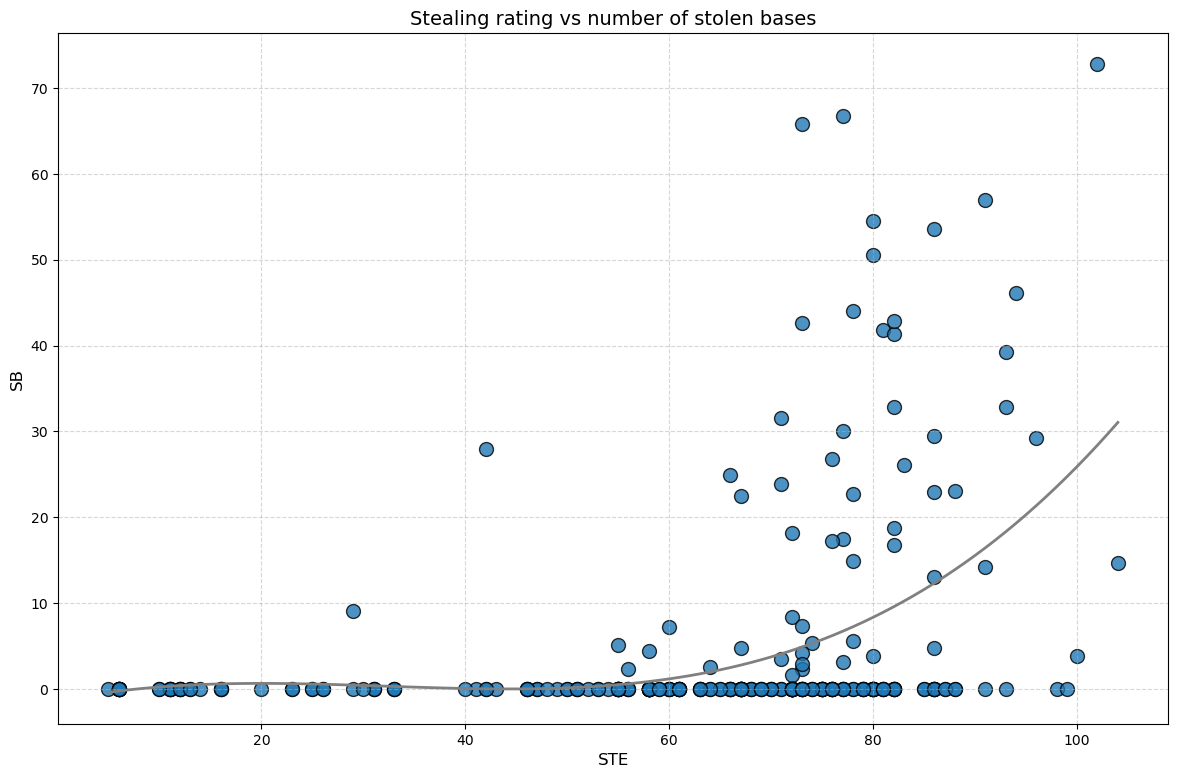

In [193]:
# Stolen bases

# Remove outliers using IQR method
Qd = df_batters_agg['SB'].astype(float).quantile(0.05)
Qu = df_batters_agg['SB'].astype(float).quantile(0.95)
IQR = Qu - Qd
lower_bound = Qd - 1.5 * IQR
upper_bound = Qu + 1.5 * IQR

# Filter the data to remove outliers
series_sb = np.nan_to_num(df_batters_agg['SB'][(df_batters_agg['SB'] >= lower_bound) & (df_batters_agg['SB'] <= upper_bound)].astype(float), nan=0.0)
series_ste = np.nan_to_num(df_batters_agg['STE'][(df_batters_agg['SB'] >= lower_bound) & (df_batters_agg['SB'] <= upper_bound)].astype(float), nan=0.0)

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a scatter plot
plt.scatter(series_ste, series_sb, s=100,
            marker='o', edgecolors='black', alpha=0.8)

# Calculate polynomial fit
coefficients = np.polyfit(series_ste, series_sb, 3)
polynomial = np.poly1d(coefficients)
x_values = np.linspace(min(series_ste), max(series_ste), 100)
y_values = polynomial(x_values)


# Plot the trendline
plt.plot(x_values, y_values, color='grey', linewidth=2, label='Trendline')

# Set labels and title
plt.xlabel('STE', fontsize=12)
plt.ylabel('SB', fontsize=12)
plt.title('Stealing rating vs number of stolen bases', fontsize=14)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Increase spacing between subplots
plt.tight_layout(pad=1.5)

# Show the plot
plt.show()


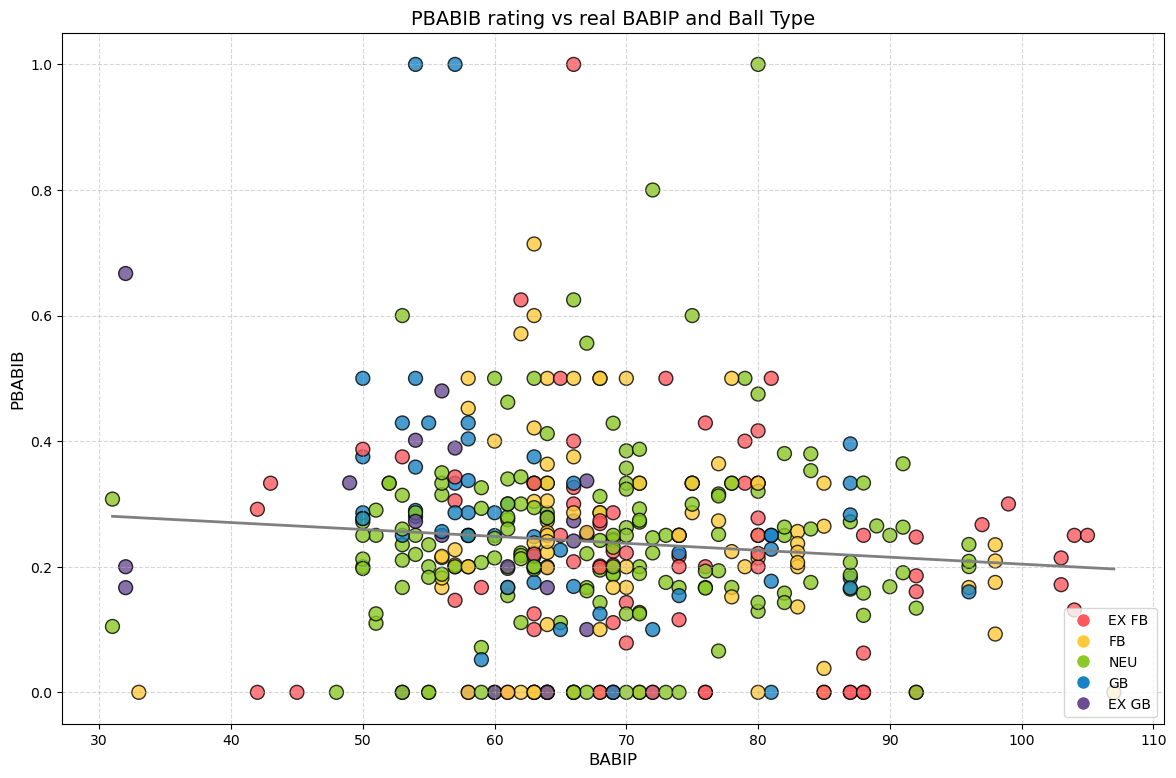

In [154]:
# Set custom color palette for different 'G/F' categories
colors = {'EX FB': '#FF595E', 'FB': '#FFCA3A', 'NEU': '#8AC926', 'GB': '#1982C4', 'EX GB': '#6A4C93'}

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a scatter plot
plt.scatter(df_pitchers_agg['PBABIP'], df_pitchers_agg['BABIP'], s=100, c=df_pitchers_agg['G/F'].map(colors),
            marker='o', edgecolors='black', alpha=0.8)

# # Calculate polynomial fit
# coefficients = np.polyfit(df_pitchers_agg['BABIP'].astype(float), df_pitchers_agg['PBABIP'].astype(float), 1)
# polynomial = np.poly1d(coefficients)
# x_values = np.linspace(min(df_pitchers_agg['BABIP']), max(df_pitchers_agg['BABIP']), 100)
# y_values = polynomial(x_values)

# from sklearn.linear_model import Ridge

# # Fit a ridge regression model
# ridge = Ridge(alpha=1.0)  # You can adjust the alpha parameter
# ridge.fit(np.vander(np.nan_to_num(df_pitchers_agg['BABIP'], nan=0.0), 3), np.nan_to_num(df_pitchers_agg['PBABIP'], nan=0.0))

# # Generate predicted values using the ridge model
# y_values = ridge.predict(np.vander(x_values, 3))

# Fit linear regression
X = sm.add_constant(np.nan_to_num(df_pitchers_agg['PBABIP'].astype(float), nan=0.0))
model = sm.OLS(np.nan_to_num(df_pitchers_agg['BABIP'].astype(float), nan=0.0), X)
results = model.fit()
intercept, slope = results.params

# Generate the linear regression line
x_values = np.linspace(min(np.nan_to_num(df_pitchers_agg['PBABIP'].astype(float), nan=0.0)), max(np.nan_to_num(df_pitchers_agg['PBABIP'].astype(float), nan=0.0)), 100)
y_values = intercept + slope * x_values

# Plot the trendline
plt.plot(x_values, y_values, color='grey', linewidth=2, label='Trendline')

# Set labels and title
plt.xlabel('PBABIP', fontsize=12)
plt.ylabel('BABIB', fontsize=12)
plt.title('PBABIB rating vs real BABIP and Ball Type', fontsize=14)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['EX FB'], markersize=10, label='EX FB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['FB'], markersize=10, label='FB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['NEU'], markersize=10, label='NEU'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['GB'], markersize=10, label='GB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['EX GB'], markersize=10, label='EX GB')]
plt.legend(handles=legend_elements, loc='lower right')

# NOTE: ADD OPACITY BASED ON PITCHED INNINGS

# Increase spacing between subplots
plt.tight_layout(pad=1.5)

# Save the plot as an image (optional)
# plt.savefig('scatter_plot_with_trendline.png', dpi=300)

# Show the plot
plt.show()


## Modeling

### Batting

In [28]:
# categorical predictors into numerical
df_batters_agg_model = pd.get_dummies(df_batters_agg, columns=['BBT','GBT','FBT'], drop_first=False)

In [80]:
predictors_batters = [
    'BABIP', 'CON', 'GAP', 'POW', 'EYE', "K's", 'BABIP vL', 'CON vL',
    'GAP vL', 'POW vL', 'EYE vL', 'K vL', 'BABIP vR', 'CON vR', 'GAP vR',
    'POW vR', 'EYE vR', 'K vR', 'BUN', 'BFH', 'BBT_Flyball', 'BBT_Groundball',
    'BBT_Line Drive', 'BBT_Normal', 'GBT_Ex. Pull', 'GBT_Normal', 'GBT_Pull',
    'GBT_Spray', 'FBT_Normal', 'FBT_Pull', 'FBT_Spray'
]

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# predictors and a target variable
X = np.asarray(df_batters_agg_model[predictors_batters].values, dtype=float)
y = np.asarray(df_batters_agg['OPS'].values, dtype=float)

# Handle missing values
X = np.nan_to_num(X, nan=0.0)  # Replace NaN values with 0
y = np.nan_to_num(y, nan=0.0)  # Replace NaN values with 0

# # Add a column of ones as the constant term to the predictor matrix
# X = np.append(arr=np.ones((X.shape[0], 1)), values=X, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Correlation

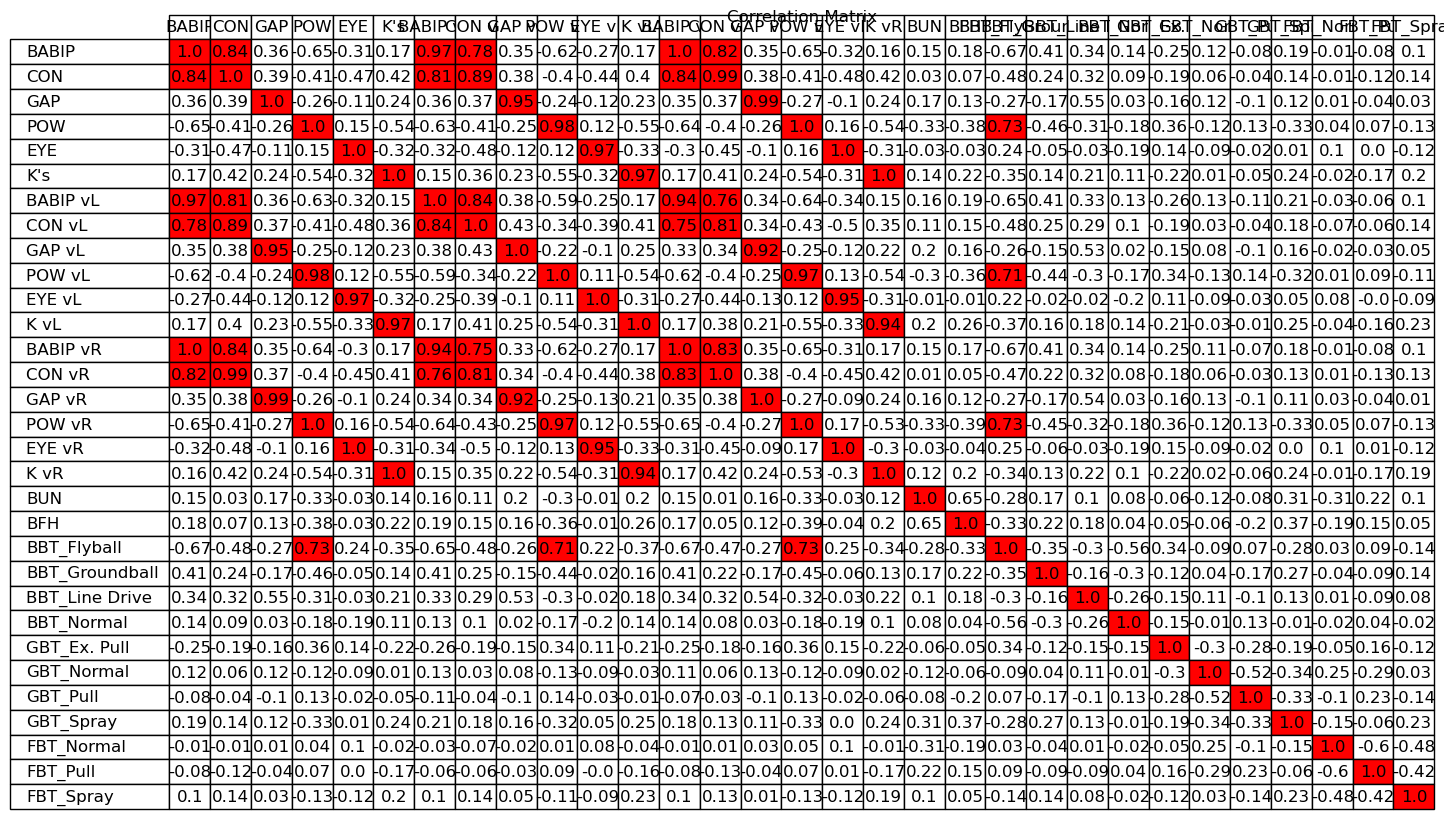

In [92]:
# Correlation matrix
corr_matrix = df_batters_agg_model[predictors_batters].corr()

# Calculate the correlation matrix
correlation_matrix = corr_matrix

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(16, 10))

# Create a table plot
table = plt.table(cellText=correlation_matrix.round(2).values,
                  cellColours=np.where(np.abs(correlation_matrix.values) >= 0.7, 'red', 'white'),
                  rowLabels=correlation_matrix.index,
                  colLabels=correlation_matrix.columns,
                  cellLoc='center',
                  loc='center')

# Set table properties
table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(12)

# Hide axis
ax.axis('off')

# Set plot title
plt.title('Correlation Matrix')

# Adjust plot layout
plt.tight_layout()

# Show the plot
plt.show()

#### Backward OLS elimination

In [71]:
import statsmodels.api as sm

def backward_elimination(X, y, pn, significance_level=0.05):
    num_predictors = X.shape[1]
    for i in range(num_predictors):
        regressor_OLS = sm.OLS(y, X).fit()
        max_pvalue = max(regressor_OLS.pvalues).astype(float)
        if max_pvalue > significance_level:
            for j in range(num_predictors - i):
                if regressor_OLS.pvalues[j].astype(float) == max_pvalue:
                    X = np.delete(X, j, 1)
                    del pn[j]
    regressor_OLS.summary()
    return X, pn

In [72]:
pred_names = predictors_batters.copy()
# Perform backward elimination
XPN = backward_elimination(X, y, pred_names, 0.2)
X = XPN[0]
pred_names = XPN[1]

# Fit the final model
regressor = sm.OLS(y, X).fit()

# Print the summary of the final model
print(regressor.summary())
print("Predictor names:", pred_names, sep="\n")

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.710
Model:                            OLS   Adj. R-squared (uncentered):              0.707
Method:                 Least Squares   F-statistic:                              230.8
Date:                Sun, 14 May 2023   Prob (F-statistic):                    1.04e-75
Time:                        08:42:42   Log-Likelihood:                         -156.73
No. Observations:                 286   AIC:                                      319.5
Df Residuals:                     283   BIC:                                      330.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Lasso & ridge

In [116]:
from sklearn.linear_model import Lasso, Ridge

pred_names = predictors_batters.copy()

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Lasso regression
lasso = Lasso(alpha=1)  # Set the regularization parameter alpha
lasso.fit(X_train, y_train)
lasso_predictions = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

# Ridge regression
ridge = Ridge(alpha=1)  # Set the regularization parameter alpha
ridge.fit(X_train, y_train)
ridge_predictions = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)

# Print the coefficients
print("Lasso Coefficients:")
for feature, coef in zip(pred_names, lasso.coef_):
    if coef != 0.00000000: print(f"{feature}: {coef:.4f}") # Print out only non-zero coefs

print("\nRidge Coefficients:")
for feature, coef in zip(pred_names, ridge.coef_):
    print(f"{feature}: {coef:.4f}")

# Print the mean squared errors
print(f"\nLasso MSE: {lasso_mse:.2f}")
print(f"Ridge MSE: {ridge_mse:.2f}")


## Ridge regression shrinks all regression coefficients towards zero


Lasso Coefficients:
EYE vL: 0.0004
EYE vR: 0.0006

Ridge Coefficients:
BABIP: -0.0481
CON: -0.0940
GAP: -0.0298
POW: 0.0202
EYE: -0.0859
K's: 0.1381
BABIP vL: 0.0260
CON vL: 0.0127
GAP vL: 0.0041
POW vL: 0.0010
EYE vL: 0.0237
K vL: -0.0291
BABIP vR: 0.0285
CON vR: 0.0702
GAP vR: 0.0305
POW vR: -0.0195
EYE vR: 0.0639
K vR: -0.1080
BUN: -0.0025
BFH: 0.0008
BBT_Flyball: -0.0042
BBT_Groundball: -0.1250
BBT_Line Drive: 0.1251
BBT_Normal: 0.0041
GBT_Ex. Pull: -0.0046
GBT_Normal: -0.0410
GBT_Pull: -0.0230
GBT_Spray: 0.0686
FBT_Normal: 0.0230
FBT_Pull: 0.0300
FBT_Spray: -0.0531

Lasso MSE: 0.12
Ridge MSE: 0.18


#### XGBoost

In [117]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

pred_names = predictors_batters.copy()

le = LabelEncoder()
y_train_l = le.fit_transform(y_train)
y_test_l = le.fit_transform(y_test)

# Create the XGBoost model
xgb_model = xgb.XGBClassifier()

# Fit the model to the training data
xgb_model.fit(X_train, y_train_l)

# Make predictions on the testing data
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test_l, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.034482758620689655


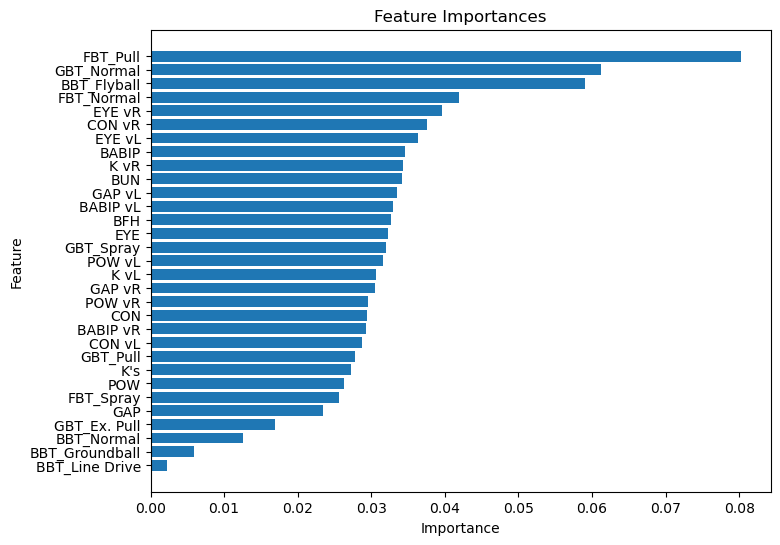

In [123]:
# Get feature importances
importance = xgb_model.feature_importances_

# Create a DataFrame to hold the feature names and importances
feature_importances = pd.DataFrame({'Feature': pred_names, 'Importance': importance})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()